# Nuclear Plant Simulation with Constant Heat Source
This notebook demonstrates the capabilities of our nuclear plant simulator. We implement the physics for:

- Reactors
- Feedwater Pump Systems
- Steam Generation Systems
- Turbine Systems
- Condenser Systems

## Setup and Imports

In [17]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Dict, Any
import time
from datetime import datetime

# Add project root to path
sys.path.append('..')
sys.path.append('../simulator')
sys.path.append('../systems')
sys.path.append('../core')

# Import nuclear simulator components
from core.sim import NuclearPlantSimulator, ControlAction
from systems.primary.reactor.heat_sources import ReactorHeatSource, ConstantHeatSource
from systems.primary.reactor.reactivity_model import create_equilibrium_state

#from utils.plant_data_logger import PlantDataLogger
#from utils.plant_plotter import PlantPlotter

# Configure matplotlib for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✅ All imports successful!")
print(f"📅 Notebook started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All imports successful!
📅 Notebook started at: 2025-06-16 15:05:30


## Create Constant Heat Source Simulator

Let's create a nuclear plant simulator using a `ConstantHeatSource` instead of using the `ReactorHeatSource`. This will allow us to easily change the state of the reactor without having to worry about individual control actions such as boration of coolant, control rod positioning, etc. You'll notice that all state management is handled automatically, with different types of physics models being registered independently.

In [18]:
# Create constant heat source
heat_source = ConstantHeatSource(rated_power_mw=3000.0)

# Create simulator with constant heat source
simulator = NuclearPlantSimulator(heat_source=heat_source, dt=1.0, enable_secondary=True)

print("🔥 Heat Source Configuration:")
print(f"   Type: {heat_source.__class__.__name__}")
print(f"   Rated Power: {heat_source.rated_power_mw:.0f} MW")
print(f"   Current Power: {heat_source.get_power_percent():.1f}%")
#print(f"   Efficiency: {heat_source.get_efficiency():.1%}")

print("\n🏭 Simulator Configuration:")
print(f"   Time Step: {simulator.dt:.1f} seconds")
print(f"   Initial Power Level: {simulator.state.power_level:.1f}%")
print(f"   Initial Fuel Temperature: {simulator.state.fuel_temperature:.1f}°C")
print(f"   Initial Coolant Temperature: {simulator.state.coolant_temperature:.1f}°C")
print(f"   Initial Control Rod Position: {simulator.state.control_rod_position:.1f}%")

Auto-registered: PrimaryReactorPhysics as primary.primaryreactor
Auto-registered: SecondaryReactorPhysics as secondary.secondaryreactor
Auto-registered: EnhancedCondenserPhysics as secondary.condenser
Auto-registered: EnhancedFeedwaterPhysics as secondary.feedwater
Auto-registered: EnhancedSteamGeneratorPhysics as secondary.steam_generator
Auto-registered: EnhancedTurbinePhysics as secondary.turbine
Auto-discovery complete: Found and registered 6 StateProvider components
State management initialized with auto-discovery: StateManager(rows=0, variables=0, categories=0, memory=0.0MB)
🔥 Heat Source Configuration:
   Type: ConstantHeatSource
   Rated Power: 3000 MW
   Current Power: 100.0%

🏭 Simulator Configuration:
   Time Step: 1.0 seconds
   Initial Power Level: 100.0%
   Initial Fuel Temperature: 410.0°C
   Initial Coolant Temperature: 310.0°C
   Initial Control Rod Position: 95.0%


## Basic Simulation Run

Let's run a basic simulation to see how the system responds to changes in demand. Here, we aim to slowly change the thermal power level of the system

In [ ]:
def run_basic_simulation(duration_seconds: int = 300) -> pd.DataFrame:
    """
    Run a basic simulation and return results as DataFrame
    """
    # Reset simulator
    simulator.reset(True)
    #simulator.primary_physics.state = create_equilibrium_state()
    # Data collection
    data = []

    print(f"🚀 Running basic simulation for {duration_seconds} seconds...")
    print(f"{'Time (s)':<8} {'Power (%)':<10} {'Fuel T (°C)':<12} {'Coolant T (°C)':<14} {'Heat Rejection Rate':<20} {'Electrical Power':<20} \
          {'Feedwater flow':<15}{'FWP-1 Status':<10}")
    print("-" * 70)
    power_level = simulator.state.power_level
    power_levels = [100., 94., 90., 84., 70., 65., 73., 82., 90., 100.,]

    for t in range(duration_seconds):
        # Step simulation

        if t % 60 == 0:
            previous_power_level = power_level
            target_power_level = power_levels[t // 60]

        power_level += (target_power_level - previous_power_level) / 60
        heat_source.set_power_setpoint(power_level)
        result = simulator.step(ControlAction.NO_ACTION, .01, load_demand=power_level)
        
        # Collect data
        data.append({
            'time': simulator.time,
            'power_level': simulator.state.power_level,
            'fuel_temperature': simulator.state.fuel_temperature,
            'coolant_temperature': simulator.state.coolant_temperature,
            'coolant_pressure': simulator.state.coolant_pressure,
            'control_rod_position': simulator.state.control_rod_position,
            'steam_flow_rate': simulator.state.steam_flow_rate,
            'steam_pressure': simulator.state.steam_pressure,
            'thermal_power_mw': result['info']['thermal_power'],
            'scram_status': simulator.secondary_physics.feedwater_system.pump_system.pumps['FWP-1'].state.status,
            'feedwater_flow_rate': simulator.secondary_physics.total_feedwater_flow,
            'heat_rejection_rate': result['info'].get('condenser_heat_rejection', 0.0)  # Use energy-balance-corrected value
        })

        # Print status every 60 seconds
        if t % 60 == 0:
            status = "SCRAM" if simulator.state.scram_status else "Normal"
            # Use energy-balance-corrected heat rejection value
            heat_rejection_corrected = result['info'].get('condenser_heat_rejection', 0.0) / 1e6  # Convert to MW
            print(f"{simulator.time:<8.0f} {simulator.state.power_level:<10.1f} "
                  f"{simulator.state.fuel_temperature:<12.0f} "
                  f"{simulator.state.coolant_temperature:<14.1f}"
                  f"{heat_rejection_corrected:<20.2f}" 
                  f"{simulator.secondary_physics.electrical_power_output:<20.2f}"
                  f"{simulator.secondary_physics.total_feedwater_flow:<15.2f}",
                  f"{simulator.secondary_physics.feedwater_system.pump_system.pumps['FWP-1'].state.status:<10}",
                )

        # Check for early termination
        if result['done']:
            print(f"\n⚠️  Simulation terminated early at {simulator.time:.0f}s due to safety system activation")
            break

    print(f"\n✅ Simulation completed!")
    print(f"   Final time: {simulator.time:.0f} seconds")
    print(f"   Final power: {simulator.state.power_level:.1f}%")
    print(f"   Final fuel temperature: {simulator.state.fuel_temperature:.1f}°C")

    return pd.DataFrame(data)
# Run the simulation
basic_data = run_basic_simulation(3600)

🚀 Running basic simulation for 600 seconds...
Time (s) Power (%)  Fuel T (°C)  Coolant T (°C) Heat Rejection Rate  Electrical Power               Feedwater flow FWP-1 Status
----------------------------------------------------------------------
1        100.0      411          310.0         3061.64             0.00                172.18          PumpStatus.RUNNING
61       99.9       471          310.0         3058.03             1025.62             1288.52         PumpStatus.RUNNING
121      93.9       526          309.1         2843.08             894.03              1161.34         PumpStatus.RUNNING
181      89.9       529          308.4         2697.78             811.02              1074.60         PumpStatus.RUNNING
241      83.8       516          307.4         2476.82             693.72              945.68          PumpStatus.RUNNING
301      69.9       487          305.2         1977.87             460.90              661.82          PumpStatus.RUNNING
361      65.1       467

## Plot Basic Results

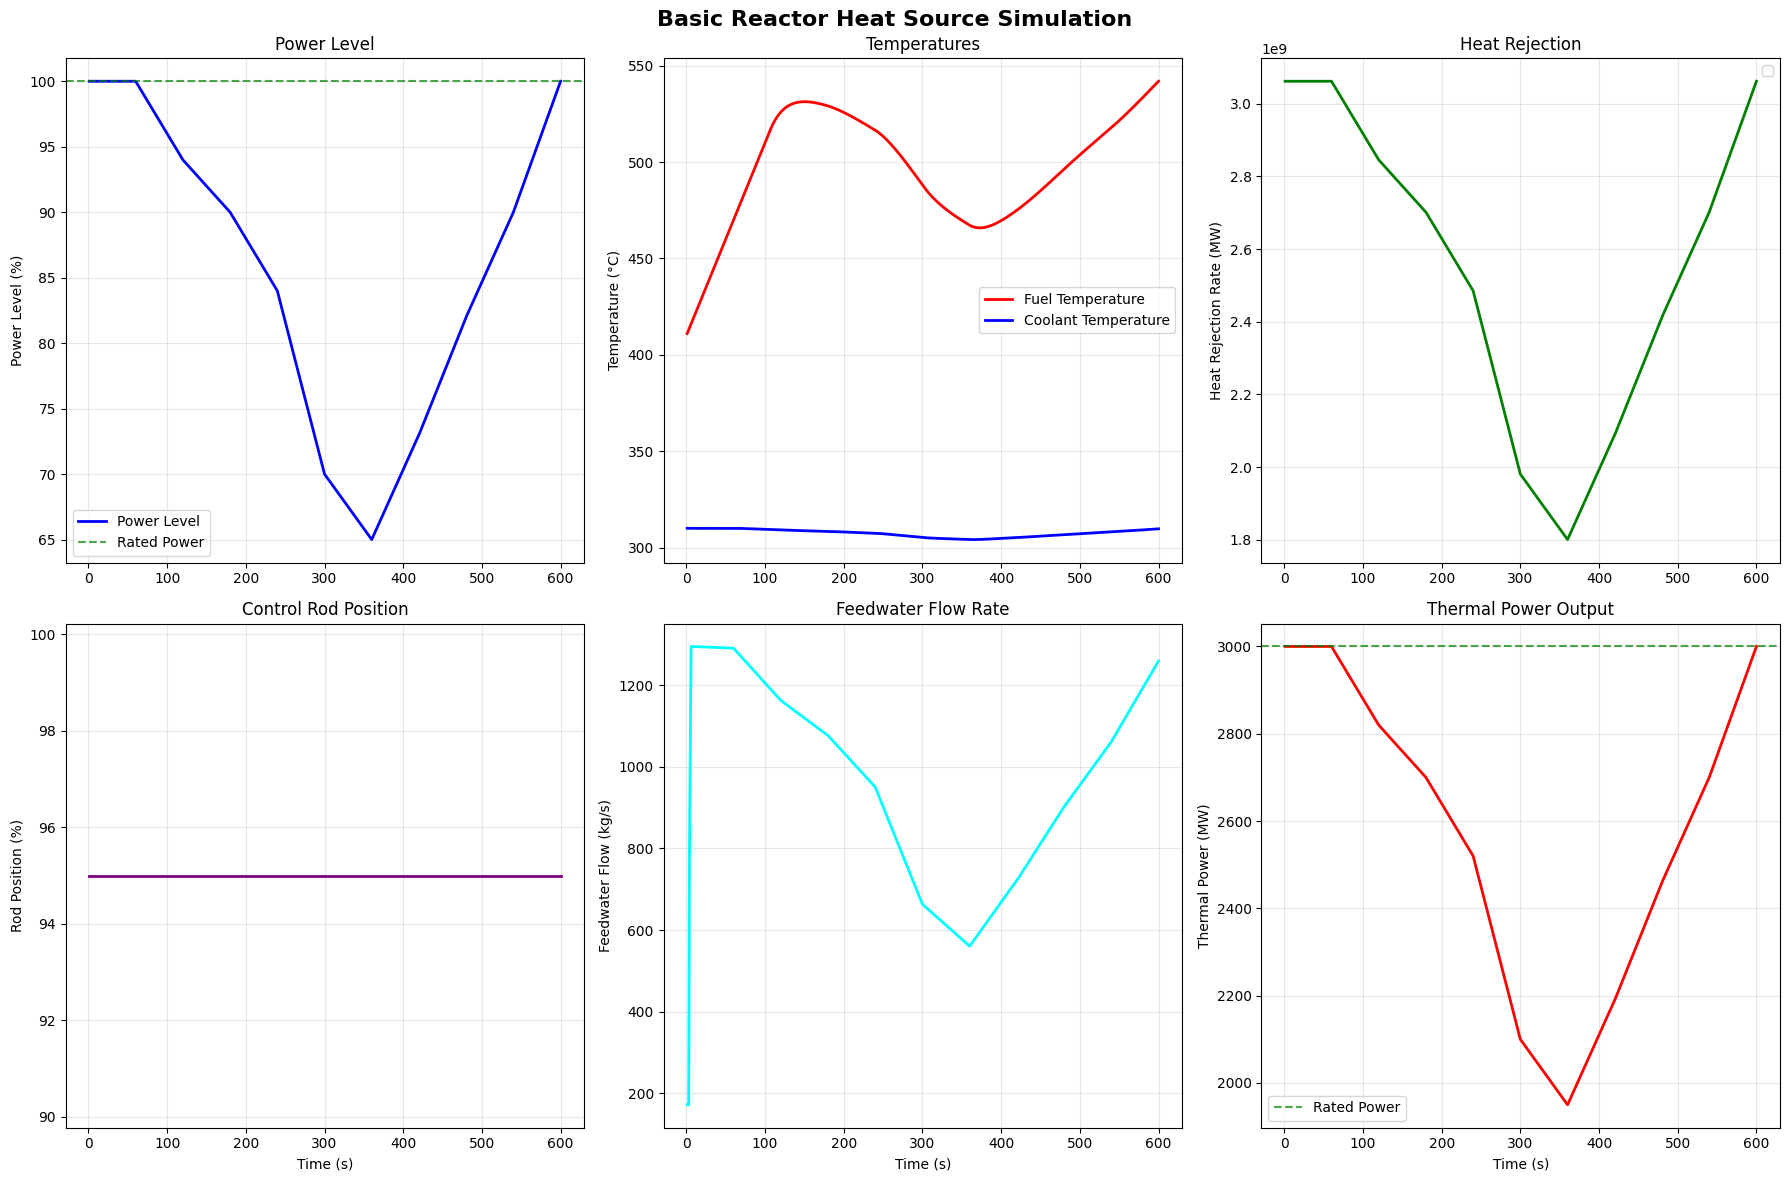

In [20]:
def plot_simulation_results(data: pd.DataFrame, title: str = "Nuclear Plant Simulation Results"):
    """
    Plot simulation results in a comprehensive dashboard
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # Power Level
    axes[0, 0].plot(data['time'], data['power_level'], 'b-', linewidth=2, label='Power Level')
    axes[0, 0].axhline(y=100, color='g', linestyle='--', alpha=0.7, label='Rated Power')
    axes[0, 0].set_ylabel('Power Level (%)')
    axes[0, 0].set_title('Power Level')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()
    
    # Temperatures
    axes[0, 1].plot(data['time'], data['fuel_temperature'], 'r-', linewidth=2, label='Fuel Temperature')
    axes[0, 1].plot(data['time'], data['coolant_temperature'], 'b-', linewidth=2, label='Coolant Temperature')
    axes[0, 1].set_ylabel('Temperature (°C)')
    axes[0, 1].set_title('Temperatures')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()
    
    # Pressure
    axes[0, 2].plot(data['time'], data['heat_rejection_rate'], 'g-', linewidth=2)
    axes[0, 2].set_ylabel('Heat Rejection Rate (MW)')
    axes[0, 2].set_title('Heat Rejection')
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].legend()
    
    # Control Rod Position
    axes[1, 0].plot(data['time'], data['control_rod_position'], 'purple', linewidth=2)
    axes[1, 0].set_ylabel('Rod Position (%)')
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_title('Control Rod Position')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Steam Flow Rate
    axes[1, 1].plot(data['time'], data['feedwater_flow_rate'], 'cyan', linewidth=2)
    axes[1, 1].set_ylabel('Feedwater Flow (kg/s)')
    axes[1, 1].set_xlabel('Time (s)')
    axes[1, 1].set_title('Feedwater Flow Rate')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Thermal Power
    axes[1, 2].plot(data['time'], data['thermal_power_mw'], 'red', linewidth=2)
    axes[1, 2].axhline(y=3000, color='g', linestyle='--', alpha=0.7, label='Rated Power')
    axes[1, 2].set_ylabel('Thermal Power (MW)')
    axes[1, 2].set_xlabel('Time (s)')
    axes[1, 2].set_title('Thermal Power Output')
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].legend()
    
    plt.tight_layout()
    plt.show()

# Plot the basic results
plot_simulation_results(basic_data, "Basic Reactor Heat Source Simulation")

## State Management

Now, we can individually access many states of our simulator. You can see that we keep track of over 550 states.

In [21]:
simulator.state_manager.get_data_info()

{'total_rows': 600,
 'total_variables': 575,
 'time_range': (np.float64(1.0), np.float64(600.0)),
 'categories': ['primary', 'secondary'],
 'memory_usage_mb': np.float64(2.734691619873047),
 'avg_collection_time_ms': np.float64(5.071636438369751)}

In [22]:
simulator.state_manager.get_available_variables()

['primary.primaryreactor.rated_power_mw',
 'primary.primaryreactor.thermal_power_mw',
 'primary.primaryreactor.total_reactivity_pcm',
 'primary.primaryreactor.scram_activated',
 'primary.primaryreactor.neutronics_neutron_flux',
 'primary.primaryreactor.neutronics_reactivity',
 'primary.primaryreactor.neutronics_reactivity_pcm',
 'primary.primaryreactor.neutronics_xenon_concentration',
 'primary.primaryreactor.neutronics_iodine_concentration',
 'primary.primaryreactor.neutronics_samarium_concentration',
 'primary.primaryreactor.thermal_fuel_temperature',
 'primary.primaryreactor.thermal_coolant_temperature',
 'primary.primaryreactor.thermal_coolant_pressure',
 'primary.primaryreactor.thermal_coolant_flow_rate',
 'primary.primaryreactor.thermal_coolant_void_fraction',
 'primary.primaryreactor.thermal_thermal_power',
 'primary.primaryreactor.steam_steam_temperature',
 'primary.primaryreactor.steam_steam_pressure',
 'primary.primaryreactor.steam_steam_flow_rate',
 'primary.primaryreactor.s

## Plotting
We can plot any of the states using the name stored within the state manager.

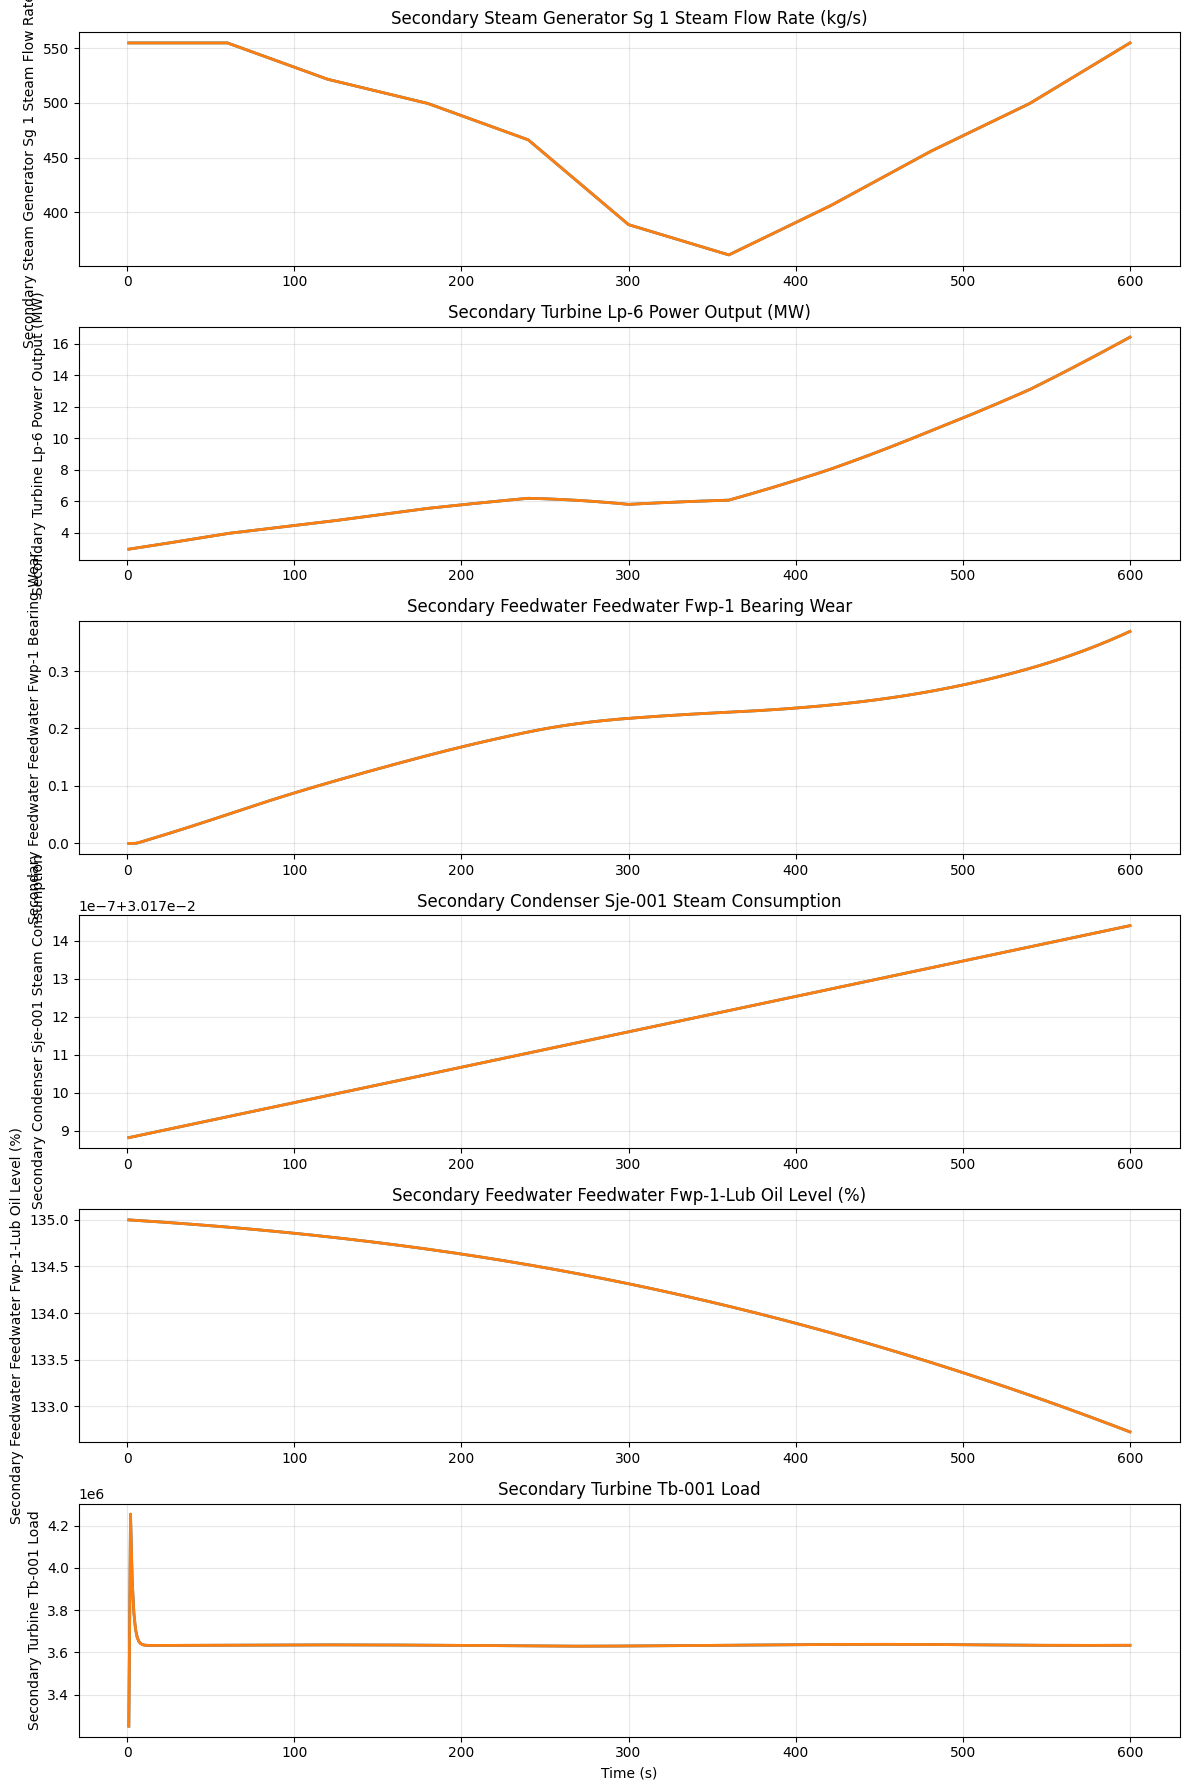

In [23]:
simulator.plot_parameters(['secondary.steam_generator.sg_1_steam_flow_rate',
                          'secondary.turbine.LP-6_power_output',
                          'secondary.feedwater.feedwater.FWP-1_bearing_wear',
                          'secondary.condenser.SJE-001_steam_consumption',
                          'secondary.feedwater.feedwater.FWP-1-LUB_oil_level',
                          'secondary.turbine.TB-001_load',
                          ])

## Other functionality

We can easily view all of our timeseries data as a pandas dataframe, or we can export to a csv. We can export a subset of data to csv.

In [24]:
simulator.state_manager.data

,time,primary.primaryreactor.rated_power_mw,primary.primaryreactor.thermal_power_mw,primary.primaryreactor.total_reactivity_pcm,primary.primaryreactor.scram_activated,primary.primaryreactor.neutronics_neutron_flux,primary.primaryreactor.neutronics_reactivity,primary.primaryreactor.neutronics_reactivity_pcm,primary.primaryreactor.neutronics_xenon_concentration,primary.primaryreactor.neutronics_iodine_concentration,...,secondary.turbine.ETC-001-LUB_hp_journal_bearing_wear,secondary.turbine.ETC-001-LUB_hp_journal_bearing_performance,secondary.turbine.ETC-001-LUB_lp_journal_bearing_wear,secondary.turbine.ETC-001-LUB_lp_journal_bearing_performance,secondary.turbine.ETC-001-LUB_thrust_bearing_wear,secondary.turbine.ETC-001-LUB_thrust_bearing_performance,secondary.turbine.ETC-001-LUB_seal_oil_system_wear,secondary.turbine.ETC-001-LUB_seal_oil_system_performance,secondary.turbine.ETC-001-LUB_oil_coolers_wear,secondary.turbine.ETC-001-LUB_oil_coolers_performance
0,1.0,3000.0,3000.0,0.0,False,1.000000e+13,0.0,0.0,2.800000e+15,1.500000e+16,...,0.000000e+00,0.690161,0.000000e+00,0.721145,0.000000e+00,0.566226,0.003792,0.628099,0.000193,0.876063
1,2.0,3000.0,3000.0,0.0,False,1.000000e+13,0.0,0.0,2.800000e+15,1.500000e+16,...,2.945016e+04,0.100000,4.537979e+03,0.100000,2.043875e+07,0.100000,0.028756,0.399281,0.000443,0.799996
2,3.0,3000.0,3000.0,0.0,False,1.000000e+13,0.0,0.0,2.800000e+15,1.500000e+16,...,7.724462e+04,0.100000,1.151688e+04,0.100000,6.049272e+07,0.100000,0.054423,0.398639,0.000693,0.799993
3,4.0,3000.0,3000.0,0.0,False,1.000000e+13,0.0,0.0,2.800000e+15,1.500000e+16,...,1.189351e+05,0.100000,1.769760e+04,0.100000,9.362893e+07,0.100000,0.099477,0.397513,0.000943,0.799991
4,5.0,3000.0,3000.0,0.0,False,1.000000e+13,0.0,0.0,2.800000e+15,1.500000e+16,...,1.577135e+05,0.100000,2.349304e+04,0.100000,1.235977e+08,0.100000,0.144889,0.396378,0.001193,0.799988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,596.0,3000.0,2980.0,0.0,False,1.000000e+13,0.0,0.0,2.800000e+15,1.500000e+16,...,2.143038e+07,0.100000,3.229124e+06,0.100000,1.608944e+10,0.100000,522.189715,0.100000,0.148943,0.798511
596,597.0,3000.0,2985.0,0.0,False,1.000000e+13,0.0,0.0,2.800000e+15,1.500000e+16,...,2.146636e+07,0.100000,3.234546e+06,0.100000,1.611645e+10,0.100000,523.244041,0.100000,0.149193,0.798508
597,598.0,3000.0,2990.0,0.0,False,1.000000e+13,0.0,0.0,2.800000e+15,1.500000e+16,...,2.150234e+07,0.100000,3.239968e+06,0.100000,1.614346e+10,0.100000,524.307977,0.100000,0.149443,0.798506
598,599.0,3000.0,2995.0,0.0,False,1.000000e+13,0.0,0.0,2.800000e+15,1.500000e+16,...,2.153832e+07,0.100000,3.245390e+06,0.100000,1.617047e+10,0.100000,525.362570,0.100000,0.149693,0.798503


In [25]:
simulator.export_state_data("all_results.csv")

Exported 600 rows to all_results.csv


In [26]:
simulator.export_state_data_by_category('primary', 'primary_results.csv')

Exported 600 rows of primary data to primary_results.csv


In [27]:
simulator.export_state_data_by_subcategory("secondary", "feedwater", "feedwater_results.csv")

Exported 600 rows of secondary.feedwater data to feedwater_results.csv
